# 基本信息
1. 实验名称：前馈神经网络实验
2. 姓名：戴斌斌
3. 学号：20281239
4. 日期：2022/10/22

---

# 一、任务1-手动实现前馈神经网络

## 1.1 任务内容

1. 任务具体要求  
手动实现前馈神经网络解决上述回归、二分类、多分类任务
2. 任务目的  
学习前馈神经网络在回归、二分类和多分类任务上的应用
3. 任务算法或原理介绍  
前馈神经网络组成  
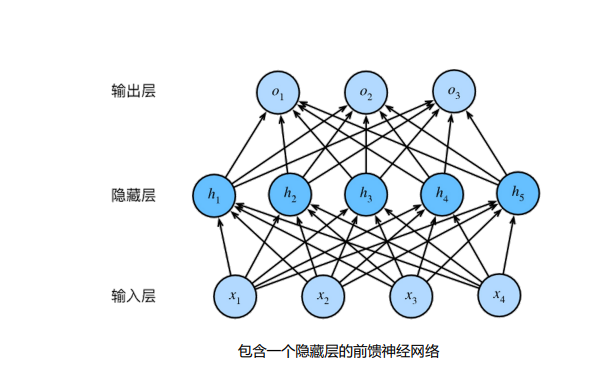
4. 任务所用数据集
    1. 回归任务数据集：
        + 数据集的大小为10000且训练集大小为7000，测试集大小为3000，数据集的样本特征维度p为500，且服从如下的高维线性函数：
    $$y = 0.028 + \sum_{i=1}^{p}0.0056x_i + \epsilon$$
    2. 二分类数据集：  
        + 两个数据集的大小均为10000且训练集大小为7000，测试集大小为3000。  
        + 两个数据集的样本特征x的维度均为200，且分别服从均值互为相反数且方差相同的正态分布。  
        + 两个数据集的样本标签分别为0和1。   
    3. MNIST手写体数据集:  
        + 该数据集包含60,000个用于训练的图像样本和10,000个用于测试的图像样本。  
        + 图像是固定大小(28x28像素)，其值为0到1。为每个图像都被平展并转换为784  
        
## 1.2 任务思路及代码  

1. 构建数据集
2. 构建前馈神经网络，损失函数，优化函数
3. 使用网络预测结果，得到损失值  
4. 进行反向传播，和梯度更新  
5. 对loss、acc等指标进行分析

### 1.2.0数据集定义

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.nn.functional import cross_entropy, binary_cross_entropy
from torch.nn import CrossEntropyLoss
from torchvision import transforms
from sklearn import  metrics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 如果有gpu则在gpu上计算 加快计算速度
# 数据集定义
# 构建回归数据集合 - traindataloader1, testdataloader1
data_num, train_num, test_num = 10000, 7000, 3000 # 分别为样本总数量，训练集样本数量和测试集样本数量
true_w, true_b = 0.0056 * torch.ones(500,1), 0.028 
features = torch.randn(10000, 500)
labels = torch.matmul(features,true_w) + true_b # 按高斯分布
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)
# 划分训练集和测试集
train_features, test_features = features[:train_num,:], features[train_num:,:]
train_labels, test_labels = labels[:train_num], labels[train_num:]
batch_size = 128
traindataset1 = torch.utils.data.TensorDataset(train_features,train_labels)
testdataset1 = torch.utils.data.TensorDataset(test_features, test_labels)
traindataloader1 = torch.utils.data.DataLoader(dataset=traindataset1,batch_size=batch_size,shuffle=True)
testdataloader1 = torch.utils.data.DataLoader(dataset=testdataset1,batch_size=batch_size,shuffle=True)

# 构二分类数据集合
data_num, train_num, test_num = 10000, 7000, 3000  # 分别为样本总数量，训练集样本数量和测试集样本数量
# 第一个数据集 符合均值为 0.5 标准差为1 得分布
features1 = torch.normal(mean=0.2, std=2, size=(data_num, 200), dtype=torch.float32)
labels1 = torch.ones(data_num)
# 第二个数据集 符合均值为 -0.5 标准差为1的分布
features2 = torch.normal(mean=-0.2, std=2, size=(data_num, 200), dtype=torch.float32)
labels2 = torch.zeros(data_num)

# 构建训练数据集
train_features2 = torch.cat((features1[:train_num], features2[:train_num]), dim=0)  # size torch.Size([14000, 200])
train_labels2 = torch.cat((labels1[:train_num], labels2[:train_num]), dim=-1)  # size  torch.Size([6000, 200])
# 构建测试数据集
test_features2 = torch.cat((features1[train_num:], features2[train_num:]), dim=0)  # torch.Size([14000])
test_labels2 = torch.cat((labels1[train_num:], labels2[train_num:]), dim=-1)  # torch.Size([6000])
batch_size = 128
# Build the training and testing dataset
traindataset2 = torch.utils.data.TensorDataset(train_features2, train_labels2)
testdataset2 = torch.utils.data.TensorDataset(test_features2, test_labels2)
traindataloader2 = torch.utils.data.DataLoader(dataset=traindataset2,batch_size=batch_size,shuffle=True)
testdataloader2 = torch.utils.data.DataLoader(dataset=testdataset2,batch_size=batch_size,shuffle=True)

# 定义多分类数据集 - train_dataloader - test_dataloader
batch_size = 128
# Build the training and testing dataset
traindataset3 = torchvision.datasets.FashionMNIST(root='E:\\DataSet\\FashionMNIST\\Train',
                                                  train=True,
                                                  download=True,
                                                  transform=transforms.ToTensor())
testdataset3 = torchvision.datasets.FashionMNIST(root='E:\\DataSet\\FashionMNIST\\Test',
                                                 train=False,
                                                 download=True,
                                                 transform=transforms.ToTensor())
traindataloader3 = torch.utils.data.DataLoader(traindataset3, batch_size=batch_size, shuffle=True)
testdataloader3 = torch.utils.data.DataLoader(testdataset3, batch_size=batch_size, shuffle=False)
# 绘制图像的代码
def picture(name, trainl, testl, type='Loss'):
    plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
    plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
    plt.title(name) # 命名
    plt.plot(trainl, c='g', label='Train '+ type)
    plt.plot(testl, c='r', label='Test '+type)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
print(f'回归数据集   样本总数量{len(traindataset1) + len(testdataset1)},训练样本数量{len(traindataset1)},测试样本数量{len(testdataset1)}')
print(f'二分类数据集 样本总数量{len(traindataset2) + len(testdataset2)},训练样本数量{len(traindataset2)},测试样本数量{len(testdataset2)}')
print(f'多分类数据集 样本总数量{len(traindataset3) + len(testdataset3)},训练样本数量{len(traindataset3)},测试样本数量{len(testdataset3)}')

回归数据集   样本总数量10000,训练样本数量7000,测试样本数量3000
二分类数据集 样本总数量20000,训练样本数量14000,测试样本数量6000
多分类数据集 样本总数量70000,训练样本数量60000,测试样本数量10000


### 1.2.1 手动实现前馈网络-回归任务  


In [2]:
# 定义自己的前馈神经网络
class MyNet1():
    def __init__(self):
        # 设置隐藏层和输出层的节点数
        num_inputs, num_hiddens, num_outputs = 500, 256, 1
        w_1 = torch.tensor(np.random.normal(0,0.01,(num_hiddens,num_inputs)),dtype=torch.float32,requires_grad=True)
        b_1 = torch.zeros(num_hiddens, dtype=torch.float32,requires_grad=True)
        w_2 = torch.tensor(np.random.normal(0, 0.01,(num_outputs, num_hiddens)),dtype=torch.float32,requires_grad=True)
        b_2 = torch.zeros(num_outputs,dtype=torch.float32, requires_grad=True)
        self.params = [w_1, b_1, w_2, b_2]
        
        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0],-1)
        self.hidden_layer = lambda x: self.my_relu(torch.matmul(x,w_1.t())+b_1)
        self.output_layer = lambda x: torch.matmul(x,w_2.t()) + b_2
        
    def my_relu(self, x):
        return torch.max(input=x,other=torch.tensor(0.0))
    
    def forward(self,x):
        x = self.input_layer(x)
        x = self.my_relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x
def mySGD(params, lr, batchsize):
    for param in params:
        param.data -= lr*param.grad / batchsize
        
def mse(pred, true):
    ans = torch.sum((true-pred)**2) / len(pred)
    # print(ans)
    return ans

# 训练
model1 = MyNet1()  # logistics模型
criterion = CrossEntropyLoss()   # 损失函数
lr = 0.05   # 学习率
batchsize = 128 
epochs = 40 #训练轮数
train_all_loss1 = [] # 记录训练集上得loss变化
test_all_loss1 = [] #记录测试集上的loss变化
begintime1 = time.time()
for epoch in range(epochs):
    train_l = 0
    for data, labels in traindataloader1:
        pred = model1.forward(data)
        train_each_loss = mse(pred.view(-1,1), labels.view(-1,1)) #计算每次的损失值
        train_each_loss.backward() # 反向传播
        mySGD(model1.params, lr, batchsize) # 使用小批量随机梯度下降迭代模型参数
        # 梯度清零
        train_l += train_each_loss.item()
        for param in model1.params:
            param.grad.data.zero_()
        # print(train_each_loss)
    train_all_loss1.append(train_l) # 添加损失值到列表中
    with torch.no_grad():
        test_loss = 0
        for data, labels in traindataloader1:
            pred = model1.forward(data)
            test_each_loss = mse(pred, labels)
            test_loss += test_each_loss.item()
        test_all_loss1.append(test_loss)
    if epoch==0 or (epoch+1) % 4 == 0:
        print('epoch: %d | train loss:%.5f | test loss:%.5f'%(epoch+1,train_all_loss1[-1],test_all_loss1[-1]))
endtime1 = time.time()
print("手动实现前馈网络-回归实验 %d轮 总用时: %.3fs"%(epochs,endtime1-begintime1))

epoch: 1 | train loss:0.99942 | test loss:0.98961
epoch: 4 | train loss:0.95575 | test loss:0.95139
epoch: 8 | train loss:0.92916 | test loss:0.92745
epoch: 12 | train loss:0.91589 | test loss:0.91432
epoch: 16 | train loss:0.90719 | test loss:0.90906
epoch: 20 | train loss:0.90161 | test loss:0.90383
epoch: 24 | train loss:0.89873 | test loss:0.89601
epoch: 28 | train loss:0.89295 | test loss:0.89194
epoch: 32 | train loss:0.88793 | test loss:0.88744
epoch: 36 | train loss:0.88431 | test loss:0.88412
epoch: 40 | train loss:0.87845 | test loss:0.87751
手动实现前馈网络-回归实验 40轮 总用时: 8.815s



### 1.2.2 手动前馈网络-二分类任务  


In [3]:
# 定义自己的前馈神经网络
class MyNet2():
    def __init__(self):
        # 设置隐藏层和输出层的节点数
        num_inputs, num_hiddens, num_outputs = 200, 256, 1
        w_1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float32,
                           requires_grad=True)
        b_1 = torch.zeros(num_hiddens, dtype=torch.float32, requires_grad=True)
        w_2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float32,
                           requires_grad=True)
        b_2 = torch.zeros(num_outputs, dtype=torch.float32, requires_grad=True)
        self.params = [w_1, b_1, w_2, b_2]

        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer = lambda x: self.my_relu(torch.matmul(x, w_1.t()) + b_1)
        self.output_layer = lambda x: torch.matmul(x, w_2.t()) + b_2
        self.fn_logistic = self.logistic

    def my_relu(self, x):
        return torch.max(input=x, other=torch.tensor(0.0))

    def logistic(self, x):  # 定义logistic函数
        x = 1.0 / (1.0 + torch.exp(-x))
        return x

    # 定义前向传播
    def forward(self, x):
        x = self.input_layer(x)
        x = self.my_relu(self.hidden_layer(x))
        x = self.fn_logistic(self.output_layer(x))
        return x


def mySGD(params, lr):
    for param in params:
        param.data -= lr * param.grad

# 训练
model2 = MyNet2()
lr = 0.01  # 学习率
epochs = 40  # 训练轮数
train_all_loss2 = []  # 记录训练集上得loss变化
test_all_loss2 = []  # 记录测试集上的loss变化
train_Acc12, test_Acc12 = [], []
begintime2 = time.time()
for epoch in range(epochs):
    train_l, train_epoch_count = 0, 0
    for data, labels in traindataloader2:
        pred = model2.forward(data)
        train_each_loss = binary_cross_entropy(pred.view(-1), labels.view(-1))  # 计算每次的损失值
        train_l += train_each_loss.item()
        train_each_loss.backward()  # 反向传播
        mySGD(model2.params, lr)  # 使用随机梯度下降迭代模型参数
        # 梯度清零
        for param in model2.params:
            param.grad.data.zero_()
        # print(train_each_loss)
        train_epoch_count += (torch.tensor(np.where(pred > 0.5, 1, 0)).view(-1) == labels).sum()
    train_Acc12.append((train_epoch_count/len(traindataset2)).item())
    train_all_loss2.append(train_l)  # 添加损失值到列表中
    with torch.no_grad():
        test_l, test_epoch_count = 0, 0
        for data, labels in testdataloader2:
            pred = model2.forward(data)
            test_each_loss = binary_cross_entropy(pred.view(-1), labels.view(-1))
            test_l += test_each_loss.item()
            test_epoch_count += (torch.tensor(np.where(pred > 0.5, 1, 0)).view(-1) == labels.view(-1)).sum()
        test_Acc12.append((test_epoch_count/len(testdataset2)).item())
        test_all_loss2.append(test_l)
    if epoch == 0 or (epoch + 1) % 4 == 0:
        print('epoch: %d | train loss:%.5f | test loss:%.5f | train acc:%.5f | test acc:%.5f'  % (epoch + 1, train_all_loss2[-1], test_all_loss2[-1], train_Acc12[-1], test_Acc12[-1]))
endtime2 = time.time()
print("手动实现前馈网络-二分类实验 %d轮 总用时: %.3f" % (epochs, endtime2 - begintime2))

epoch: 1 | train loss:74.68298 | test loss:30.95729 | train acc:0.73179 | test acc:0.85817
epoch: 4 | train loss:37.94670 | test loss:14.03212 | train acc:0.91793 | test acc:0.91900
epoch: 8 | train loss:21.84983 | test loss:9.52792 | train acc:0.92350 | test acc:0.91983
epoch: 12 | train loss:19.65703 | test loss:9.13498 | train acc:0.92793 | test acc:0.91867
epoch: 16 | train loss:18.69092 | test loss:9.10440 | train acc:0.93143 | test acc:0.91850
epoch: 20 | train loss:17.92889 | test loss:9.16376 | train acc:0.93407 | test acc:0.91783
epoch: 24 | train loss:17.19131 | test loss:9.21053 | train acc:0.93729 | test acc:0.91667
epoch: 28 | train loss:16.59650 | test loss:9.27140 | train acc:0.94136 | test acc:0.91633
epoch: 32 | train loss:15.98823 | test loss:9.32542 | train acc:0.94464 | test acc:0.91700
epoch: 36 | train loss:15.40845 | test loss:9.36028 | train acc:0.94750 | test acc:0.91600
epoch: 40 | train loss:14.69034 | test loss:9.40460 | train acc:0.95107 | test acc:0.91650


### 1.2.3 手动实现前馈神经网络-多分类  


In [4]:
# 定义自己的前馈神经网络
class MyNet3():
    def __init__(self):
        # 设置隐藏层和输出层的节点数
        num_inputs, num_hiddens, num_outputs = 28 * 28, 256, 10  # 十分类问题
        w_1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float32,
                           requires_grad=True)
        b_1 = torch.zeros(num_hiddens, dtype=torch.float32, requires_grad=True)
        w_2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float32,
                           requires_grad=True)
        b_2 = torch.zeros(num_outputs, dtype=torch.float32, requires_grad=True)
        self.params = [w_1, b_1, w_2, b_2]

        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer = lambda x: self.my_relu(torch.matmul(x, w_1.t()) + b_1)
        self.output_layer = lambda x: torch.matmul(x, w_2.t()) + b_2

    def my_relu(self, x):
        return torch.max(input=x, other=torch.tensor(0.0))
    
    # 定义前向传播
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x


def mySGD(params, lr, batchsize):
    for param in params:
        param.data -= lr * param.grad / batchsize

# 训练
model3 = MyNet3()  # logistics模型
criterion = cross_entropy  # 损失函数
lr = 0.1  # 学习率
epochs = 40  # 训练轮数
train_all_loss3 = []  # 记录训练集上得loss变化
test_all_loss3 = []  # 记录测试集上的loss变化
train_ACC13, test_ACC13 = [], [] # 记录正确的个数
begintime3 = time.time()
for epoch in range(epochs):
    train_l,train_acc_num = 0, 0
    for data, labels in traindataloader3:
        pred = model3.forward(data)
        train_each_loss = criterion(pred, labels)  # 计算每次的损失值
        train_l += train_each_loss.item()
        train_each_loss.backward()  # 反向传播
        mySGD(model3.params, lr, 128)  # 使用小批量随机梯度下降迭代模型参数
        # 梯度清零
        train_acc_num += (pred.argmax(dim=1)==labels).sum().item()
        for param in model3.params:
            param.grad.data.zero_()
        # print(train_each_loss)
    train_all_loss3.append(train_l)  # 添加损失值到列表中
    train_ACC13.append(train_acc_num / len(traindataset3)) # 添加准确率到列表中
    with torch.no_grad():
        test_l, test_acc_num = 0, 0
        for data, labels in testdataloader3:
            pred = model3.forward(data)
            test_each_loss = criterion(pred, labels)
            test_l += test_each_loss.item()
            test_acc_num += (pred.argmax(dim=1)==labels).sum().item()
        test_all_loss3.append(test_l)
        test_ACC13.append(test_acc_num / len(testdataset3))   # # 添加准确率到列表中
    if epoch == 0 or (epoch + 1) % 4 == 0:
        print('epoch: %d | train loss:%.5f | test loss:%.5f | train acc: %.2f | test acc: %.2f'
              % (epoch + 1, train_l, test_l, train_ACC13[-1],test_ACC13[-1]))
endtime3 = time.time()
print("手动实现前馈网络-多分类实验 %d轮 总用时: %.3f" % (epochs, endtime3 - begintime3))

epoch: 1 | train loss:1073.97077 | test loss:179.90200 | train acc: 0.28 | test acc: 0.37
epoch: 4 | train loss:1011.44024 | test loss:167.27142 | train acc: 0.40 | test acc: 0.41
epoch: 8 | train loss:798.11303 | test loss:130.00776 | train acc: 0.54 | test acc: 0.56
epoch: 12 | train loss:622.61496 | test loss:102.61041 | train acc: 0.61 | test acc: 0.61
epoch: 16 | train loss:522.29760 | test loss:86.99840 | train acc: 0.64 | test acc: 0.63
epoch: 20 | train loss:462.32886 | test loss:77.64042 | train acc: 0.66 | test acc: 0.65
epoch: 24 | train loss:423.98086 | test loss:71.62085 | train acc: 0.68 | test acc: 0.66
epoch: 28 | train loss:397.56599 | test loss:67.46180 | train acc: 0.69 | test acc: 0.68
epoch: 32 | train loss:378.05602 | test loss:64.36001 | train acc: 0.70 | test acc: 0.69
epoch: 36 | train loss:362.75410 | test loss:61.88922 | train acc: 0.72 | test acc: 0.71
epoch: 40 | train loss:349.93644 | test loss:59.81727 | train acc: 0.73 | test acc: 0.72
手动实现前馈网络-多分类实验 40轮

## 1.3 实验结果分析  
将上述前馈网络回归任务每一轮得训练和测试得损失值绘制成图表，如下图：

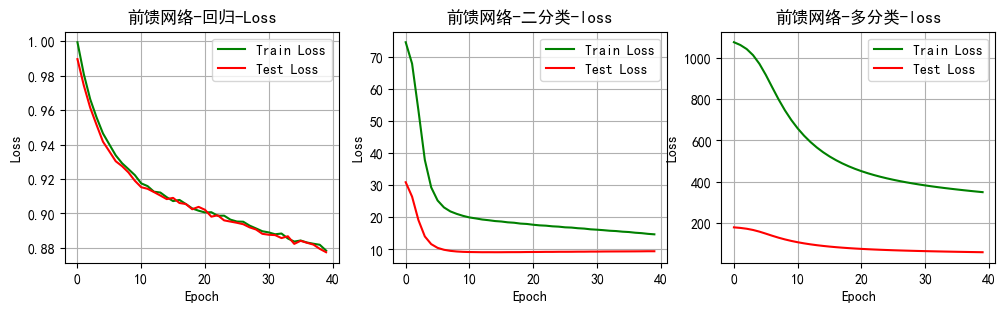

In [5]:
plt.figure(figsize=(12,3))
plt.title('Loss')
plt.subplot(131)
picture('前馈网络-回归-Loss',train_all_loss1,test_all_loss1)
plt.subplot(132)
picture('前馈网络-二分类-loss',train_all_loss2,test_all_loss2)
plt.subplot(133)
picture('前馈网络-多分类-loss',train_all_loss3,test_all_loss3)
plt.show()

将上述的二分类和多分类的正确率绘制成表格

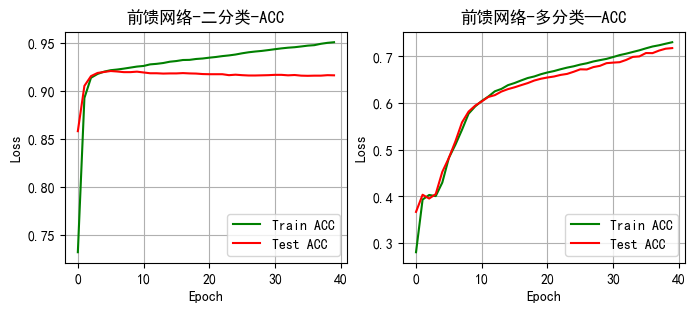

In [6]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
picture('前馈网络-二分类-ACC',train_Acc12,test_Acc12,type='ACC')
plt.subplot(122)
picture('前馈网络-多分类—ACC', train_ACC13,test_ACC13, type='ACC')
plt.show()

---

# 二、任务2-利用torch.nn实现前馈神经网络

## 2.1 任务内容

1. 任务具体要求  
利用torch.nn实现前馈神经网络解决上述回归、二分类、多分类任务
2. 任务目的  
利用torch.nn实现的前馈神经网络完成对应的回归、分类等任务
3. 任务算法或原理介绍  
见任务一
4. 任务所用数据集（若此前已介绍过则可略） 
见任务一

## 2.2 任务思路及代码  
1. 构建回归、二分类、多分类数据集
2. 利用torch.nn构建前馈神经网络，损失函数，优化函数
3. 使用网络预测结果，得到损失值  
4. 进行反向传播，和梯度更新  
5. 对loss、acc等指标进行分析

### 2.2.1 torch.nn实现前馈神经网络-回归任务

In [7]:
from torch.optim import SGD
from torch.nn import MSELoss
# 利用torch.nn实现前馈神经网络-回归任务 代码
# 定义自己的前馈神经网络
class MyNet21(nn.Module):
    def __init__(self):
        super(MyNet21, self).__init__()
        # 设置隐藏层和输出层的节点数
        num_inputs, num_hiddens, num_outputs = 500, 256, 1
        # 定义模型结构
        self.input_layer = nn.Flatten()
        self.hidden_layer = nn.Linear(num_inputs, num_hiddens)
        self.output_layer = nn.Linear(num_hiddens, num_outputs)
        self.relu = nn.ReLU()

    # 定义前向传播
    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

# 训练
model21 = MyNet21()  # logistics模型
model21 = model21.to(device)
print(model21)
criterion = MSELoss()  # 损失函数
criterion = criterion.to(device)
optimizer = SGD(model21.parameters(), lr=0.1)  # 优化函数
epochs = 40  # 训练轮数
train_all_loss21 = []  # 记录训练集上得loss变化
test_all_loss21 = []  # 记录测试集上的loss变化
begintime21 = time.time()
for epoch in range(epochs):
    train_l = 0
    for data, labels in traindataloader1:
        data, labels = data.to(device=device), labels.to(device)
        pred = model21(data)
        train_each_loss = criterion(pred.view(-1, 1), labels.view(-1, 1))  # 计算每次的损失值
        optimizer.zero_grad()  # 梯度清零
        train_each_loss.backward()  # 反向传播
        optimizer.step()  # 梯度更新
        train_l += train_each_loss.item()
    train_all_loss21.append(train_l)  # 添加损失值到列表中
    with torch.no_grad():
        test_loss = 0
        for data, labels in testdataloader1:
            data, labels = data.to(device), labels.to(device)
            pred = model21(data)
            test_each_loss = criterion(pred,labels)
            test_loss += test_each_loss.item()
        test_all_loss21.append(test_loss)
    if epoch == 0 or (epoch + 1) % 10 == 0:
        print('epoch: %d | train loss:%.5f | test loss:%.5f' % (epoch + 1, train_all_loss21[-1], test_all_loss21[-1]))
endtime21 = time.time()
print("torch.nn实现前馈网络-回归实验 %d轮 总用时: %.3fs" % (epochs, endtime21 - begintime21))


MyNet21(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=500, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:160.49464 | test loss:0.46474
epoch: 10 | train loss:0.24424 | test loss:0.14694
epoch: 20 | train loss:0.15098 | test loss:0.13187
epoch: 30 | train loss:0.10497 | test loss:0.12752
epoch: 40 | train loss:0.07492 | test loss:0.12747
torch.nn实现前馈网络-回归实验 40轮 总用时: 6.726s


### 2.2.2 torch.nn实现前馈神经网络-二分类

In [8]:
# 利用torch.nn实现前馈神经网络-二分类任务
import time
from torch.optim import SGD
from torch.nn.functional import binary_cross_entropy
# 利用torch.nn实现前馈神经网络-回归任务 代码
# 定义自己的前馈神经网络
class MyNet22(nn.Module):
    def __init__(self):
        super(MyNet22, self).__init__()
        # 设置隐藏层和输出层的节点数
        num_inputs, num_hiddens, num_outputs = 200, 256, 1
        # 定义模型结构
        self.input_layer = nn.Flatten()
        self.hidden_layer = nn.Linear(num_inputs, num_hiddens)
        self.output_layer = nn.Linear(num_hiddens, num_outputs)
        self.relu = nn.ReLU()

    def logistic(self, x):  # 定义logistic函数
        x = 1.0 / (1.0 + torch.exp(-x))
        return x
    # 定义前向传播
    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(self.hidden_layer(x))
        x = self.logistic(self.output_layer(x))
        return x

# 训练
model22 = MyNet22()  # logistics模型
model22 = model22.to(device)
print(model22)
optimizer = SGD(model22.parameters(), lr=0.001)  # 优化函数
epochs = 40  # 训练轮数
train_all_loss22 = []  # 记录训练集上得loss变化
test_all_loss22 = []  # 记录测试集上的loss变化
train_ACC22, test_ACC22 = [], []
begintime22 = time.time()
for epoch in range(epochs):
    train_l, train_epoch_count, test_epoch_count = 0, 0, 0 # 每一轮的训练损失值 训练集正确个数 测试集正确个数
    for data, labels in traindataloader2:
        data, labels = data.to(device), labels.to(device)
        pred = model22(data)
        train_each_loss = binary_cross_entropy(pred.view(-1), labels.view(-1))  # 计算每次的损失值
        optimizer.zero_grad()  # 梯度清零
        train_each_loss.backward()  # 反向传播
        optimizer.step()  # 梯度更新
        train_l += train_each_loss.item()
        pred = torch.tensor(np.where(pred.cpu()>0.5, 1, 0))  # 大于 0.5时候，预测标签为 1 否则为0
        each_count = (pred.view(-1) == labels.cpu()).sum() # 每一个batchsize的正确个数
        train_epoch_count += each_count # 计算每个epoch上的正确个数
    train_ACC22.append(train_epoch_count / len(traindataset2))
    train_all_loss22.append(train_l)  # 添加损失值到列表中
    with torch.no_grad():
        test_loss, each_count = 0, 0
        for data, labels in testdataloader2:
            data, labels = data.to(device), labels.to(device)
            pred = model22(data)
            test_each_loss = binary_cross_entropy(pred.view(-1),labels)
            test_loss += test_each_loss.item()
            # .cpu 为转换到cpu上计算
            pred = torch.tensor(np.where(pred.cpu() > 0.5, 1, 0))
            each_count = (pred.view(-1)==labels.cpu().view(-1)).sum()
            test_epoch_count += each_count
        test_all_loss22.append(test_loss)
        test_ACC22.append(test_epoch_count / len(testdataset2))
    if epoch == 0 or (epoch + 1) % 4 == 0:
        print('epoch: %d | train loss:%.5f test loss:%.5f | train acc:%.5f | test acc:%.5f' % (epoch + 1, train_all_loss22[-1], 
                                                                                               test_all_loss22[-1], train_ACC22[-1], test_ACC22[-1]))

endtime22 = time.time()
print("torch.nn实现前馈网络-二分类实验 %d轮 总用时: %.3fs" % (epochs, endtime22 - begintime22))

MyNet22(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=200, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:77.91284 test loss:32.05722 | train acc:0.51857 | test acc:0.55317
epoch: 4 | train loss:66.44407 test loss:27.58077 | train acc:0.70921 | test acc:0.74583
epoch: 8 | train loss:55.68512 test loss:23.17603 | train acc:0.82386 | test acc:0.83933
epoch: 12 | train loss:47.51888 test loss:19.81907 | train acc:0.86571 | test acc:0.87433
epoch: 16 | train loss:41.27293 test loss:17.30285 | train acc:0.88714 | test acc:0.89033
epoch: 20 | train loss:36.66265 test loss:15.42156 | train acc:0.89721 | test acc:0.89967
epoch: 24 | train loss:33.16625 test loss:14.04721 | train acc:0.90400 | test acc:0.90550
epoch: 28 | train loss:30.57805 test loss:13.02061 | train acc:0.90907 | test acc:0.90817
epoch: 32 | train loss:28.68784 test loss:12.25029 | train acc:0.

### 2.2.3 torch.nn实现前馈神经网络-多分类任务

In [18]:
# 利用torch.nn实现前馈神经网络-多分类任务
from collections import OrderedDict
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
# 定义自己的前馈神经网络
class MyNet23(nn.Module):
    """
    参数：  num_input：输入每层神经元个数，为一个列表数据
            num_hiddens：隐藏层神经元个数
            num_outs： 输出层神经元个数
            num_hiddenlayer : 隐藏层的个数
    """
    def __init__(self,num_hiddenlayer=1, num_inputs=28*28,num_hiddens=[256],num_outs=10,act='relu'):
        super(MyNet23, self).__init__()
        # 设置隐藏层和输出层的节点数
        self.num_inputs, self.num_hiddens, self.num_outputs = num_inputs,num_hiddens,num_outs # 十分类问题

        # 定义模型结构
        self.input_layer = nn.Flatten()
        # 若只有一层隐藏层
        if num_hiddenlayer ==1:
            self.hidden_layers = nn.Linear(self.num_inputs,self.num_hiddens[-1])
        else: # 若有多个隐藏层
            self.hidden_layers = nn.Sequential()
            self.hidden_layers.add_module('hidden_layer1', nn.Linear(self.num_inputs,self.num_hiddens[0]))
            for i in range(0,num_hiddenlayer-1):
                name = 'hidden_layer'+str(i+2)
                print(name)
                self.hidden_layers.add_module(name, nn.Linear(self.num_hiddens[i],self.num_hiddens[i+1]))
        self.output_layer = nn.Linear(self.num_hiddens[-1], self.num_outputs)
        # 指代需要使用什么样子的激活函数
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif act == 'tanh':
            self.act = nn.Tanh()
        elif act == 'elu':
            self.act = nn.ELU()
        print(f'你本次使用的激活函数为 {act}')

    def logistic(self, x):  # 定义logistic函数
        x = 1.0 / (1.0 + torch.exp(-x))
        return x
    # 定义前向传播
    def forward(self, x):
        x = self.input_layer(x)
        x = self.act(self.hidden_layers(x))
        x = self.output_layer(x)
        return x

# 训练
# 使用默认的参数即： num_inputs=28*28,num_hiddens=256,num_outs=10,act='relu'
model23 = MyNet23()  
model23 = model23.to(device)

# 将训练过程定义为一个函数，方便实验三和实验四调用
def train_and_test(model=model23):
    MyModel = model
    print(MyModel)
    optimizer = SGD(MyModel.parameters(), lr=0.02)  # 优化函数
    epochs = 40  # 训练轮数
    criterion = CrossEntropyLoss() # 损失函数
    train_all_loss23 = []  # 记录训练集上得loss变化
    test_all_loss23 = []  # 记录测试集上的loss变化
    train_ACC23, test_ACC23 = [], []
    begintime23 = time.time()
    for epoch in range(epochs):
        train_l, train_epoch_count, test_epoch_count = 0, 0, 0
        for data, labels in traindataloader3:
            data, labels = data.to(device), labels.to(device)
            pred = MyModel(data)
            train_each_loss = criterion(pred, labels.view(-1))  # 计算每次的损失值
            optimizer.zero_grad()  # 梯度清零
            train_each_loss.backward()  # 反向传播
            optimizer.step()  # 梯度更新
            train_l += train_each_loss.item()
            train_epoch_count += (pred.argmax(dim=1)==labels).sum()
        train_ACC23.append(train_epoch_count/len(traindataset3))
        train_all_loss23.append(train_l)  # 添加损失值到列表中
        with torch.no_grad():
            test_loss, test_epoch_count= 0, 0
            for data, labels in testdataloader3:
                data, labels = data.to(device), labels.to(device)
                pred = MyModel(data)
                test_each_loss = criterion(pred,labels)
                test_loss += test_each_loss.item()
                test_epoch_count += (pred.argmax(dim=1)==labels).sum()
            test_all_loss23.append(test_loss)
            test_ACC23.append(test_epoch_count/len(testdataset3))
        if epoch == 0 or (epoch + 1) % 4 == 0:
            print('epoch: %d | train loss:%.5f | test loss:%.5f | train acc:%5f test acc:%.5f:' % (epoch + 1, train_all_loss23[-1], test_all_loss23[-1],
                                                                                                                     train_ACC23[-1],test_ACC23[-1]))
    endtime23 = time.time()
    print("torch.nn实现前馈网络-多分类任务 %d轮 总用时: %.3fs" % (epochs, endtime23 - begintime23))
    # 返回训练集和测试集上的 损失值 与 准确率
    return train_all_loss23,test_all_loss23,train_ACC23,test_ACC23
train_all_loss23,test_all_loss23,train_ACC23,test_ACC23 = train_and_test(model=model23)

你本次使用的激活函数为 relu
MyNet23(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layers): Linear(in_features=784, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (act): ReLU()
)
epoch: 1 | train loss:528.36921 | test loss:60.23525 | train acc:0.656533 test acc:0.73450:
epoch: 4 | train loss:247.04977 | test loss:42.60844 | train acc:0.821333 test acc:0.80860:
epoch: 8 | train loss:212.63757 | test loss:37.58910 | train acc:0.843633 test acc:0.83230:
epoch: 12 | train loss:198.03288 | test loss:35.59843 | train acc:0.854317 test acc:0.83860:
epoch: 16 | train loss:187.76224 | test loss:35.20623 | train acc:0.862533 test acc:0.84240:
epoch: 20 | train loss:179.19791 | test loss:32.89550 | train acc:0.866950 test acc:0.85160:
epoch: 24 | train loss:172.26030 | test loss:31.88658 | train acc:0.871933 test acc:0.85680:
epoch: 28 | train loss:166.63145 | test loss:32.07935 | train acc:0.876650 test acc:0.85610:
epoch: 32 | train loss:

## 2.3 实验结果分析  
将上述前馈网络回归任务每一轮得训练和测试得损失值绘制成图表，如下图：

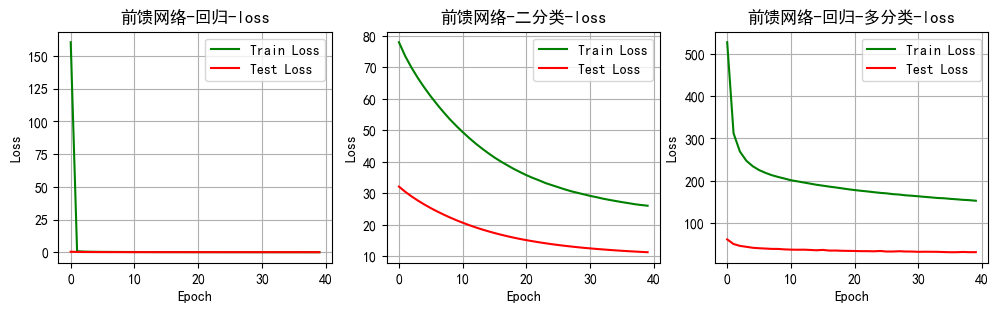

In [21]:
plt.figure(figsize=(12,3))
plt.subplot(131)
picture('前馈网络-回归-loss',train_all_loss21,test_all_loss21)
plt.subplot(132)
picture('前馈网络-二分类-loss',train_all_loss22,test_all_loss22)
plt.subplot(133)
picture('前馈网络-回归-多分类-loss',train_all_loss23,test_all_loss23)
plt.show()

将上述前馈网络回归任务每一轮得训练和测试得准确率值绘制成图表，如下图：

# 三、任务3-在多分类任务中使用至少三种不同的激活函数

## 3.1 任务内容

1. 任务具体要求  
在上述实现的多分类任务中使用至少三种不同的激活函数，本次实验使用分别使用四个激活函数：Relu、Tanh、Sigmoid、ELU
2. 任务目的  
学习不同激活函数的作用
3. 任务算法或原理介绍  
同任务二中多分类
4. 任务所用数据集（若此前已介绍过则可略） 
同见任务二中多分类数据集

## 3.2 任务思路及代码  
1. 构建回归、二分类、多分类数据集
2. 利用torch.nn构建前馈神经网络，损失函数，优化函数
3. 构建不同的激活函数
4. 使用网络预测结果，得到损失值  
5. 进行反向传播，和梯度更新  
6. 对loss、acc等指标进行分析

**默认的网络为一个隐藏层，神经元个数为[256],激活函数为relu函数**

### 3.2.1画图函数

In [22]:
def ComPlot(datalist,title='1',ylabel='Loss'):
    plt.tilte(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.plot(datalist[0],label='Relu')
    plt.plot(datalist[1],label='Tanh')
    plt.plot(datalist[2],label='Sigmoid')
    plt.plot(datalist[3],label='Elu')
    plt.legend()

### 3.2.1 使用Tanh激活函数

In [ ]:
# 使用实验二中多分类的模型定义其激活函数为 Tanh
model31 = MyNet23(1,28*28,[256],10,act='tanh') 
model31 = model31.to(device) # 若有gpu则放在gpu上训练
# 调用实验二中定义的训练函数，避免重复编写代码
train_all_loss31,test_all_loss31,train_ACC31,test_ACC31 = train_and_test(model=model31)

你本次使用的激活函数为 tanh
MyNet23(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layers): Linear(in_features=784, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (act): Tanh()
)
epoch: 1 | train loss:496.97445 | test loss:58.35568 | train acc:0.675400 test acc:0.74270:
epoch: 4 | train loss:243.13098 | test loss:41.96536 | train acc:0.823133 test acc:0.81150:
epoch: 8 | train loss:210.49945 | test loss:37.18704 | train acc:0.842933 test acc:0.83130:
epoch: 12 | train loss:196.32567 | test loss:35.88920 | train acc:0.852833 test acc:0.83710:
epoch: 16 | train loss:187.00282 | test loss:34.07224 | train acc:0.859550 test acc:0.84550:


### 3.2.2 使用Sigmoid激活函数

In [ ]:
# 使用实验二中多分类的模型定义其激活函数为 Sigmoid
model32 = MyNet23(1,28*28,[256],10,act='sigmoid') 
model32 = model32.to(device) # 若有gpu则放在gpu上训练
# 调用实验二中定义的训练函数，避免重复编写代码
train_all_loss32,test_all_loss32,train_ACC32,test_ACC32 = train_and_test(model=model32)

### 3.2.3 使用ELU激活函数

In [ ]:
# 使用实验二中多分类的模型定义其激活函数为 ELU
model33 = MyNet23(1,28*28,[256],10,act='elu') 
model33 = model33.to(device) # 若有gpu则放在gpu上训练
# 调用实验二中定义的训练函数，避免重复编写代码
train_all_loss33,test_all_loss33,train_ACC33,test_ACC33 = train_and_test(model=model31)

## 3.3实验结果分析

# 三、任务4-对多分类任务中的模型评估隐藏层层数和隐藏单元个数对实验结果的影响

## 4.1 任务内容

1. 任务具体要求  
使用不同的隐藏层层数和隐藏单元个数，进行对比实验并分析实验结果，为了体现控制变量原则，统一使用RELU为激活函数
2. 任务目的  
学习不同激活函数的作用
3. 任务算法或原理介绍  
同任务二中多分类
4. 任务所用数据集（若此前已介绍过则可略） 
同见任务二中多分类数据集

## 4.2 任务思路及代码  
1. 构建多分类数据集
2. 利用torch.nn构建前馈神经网络，损失函数，优化函数
3. 构建不同的隐藏层和隐藏神经元个数
4. 使用网络预测结果，得到损失值  
5. 进行反向传播，和梯度更新  
6. 对loss、acc等指标进行分析

**默认的网络为一个隐藏层，神经元个数为[256],激活函数为relu函数**

### 4.2.1一个隐藏层，神经元个数为[128]

In [ ]:
# 使用实验二中多分类的模型  一个隐藏层，神经元个数为[128]
model41 = MyNet23(2,28*28,256,10,act='relu') 
model41 = model41.to(device) # 若有gpu则放在gpu上训练
# 调用实验二中定义的训练函数，避免重复编写代码
train_all_loss41,test_all_loss41,train_ACC41,test_ACC41 = train_and_test(model=model41)

### 4.2.2 两个隐藏层，神经元个数分别为[512,256]

In [ ]:
# 使用实验二中多分类的模型  两个隐藏层，神经元个数为[512，256]
model42 = MyNet23(2,28*28,256,10,act='relu') 
model42 = model42.to(device) # 若有gpu则放在gpu上训练
# 调用实验二中定义的训练函数，避免重复编写代码
train_all_loss42,test_all_loss42,train_ACC42,test_ACC42 = train_and_test(model=model42)

### 4.2.3 三个隐藏层，神经元个数分别为[512,256,128]

In [ ]:
# 使用实验二中多分类的模型  两个隐藏层，神经元个数为[512，256，128]
model43 = MyNet23(2,28*28,[512,256,128],10,act='relu') 
model43 = model43.to(device) # 若有gpu则放在gpu上训练
# 调用实验二中定义的训练函数，避免重复编写代码
train_all_loss42,test_all_loss42,train_ACC42,test_ACC42 = train_and_test(model=model43)

---

# A1 实验心得

> 1. 请重视总结心得体会，该部分计分；
> 2. 至少应包括一个具体任务心得或代码排错过程，而不是仅有诸如“学到了很多”的内容。

# A2 参考文献  
参考课程PPT